In [ ]:
# 10-1
!mkdir chap10
%cd ./chap10

In [2]:
# 10-3
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = "tohoku-nlp/bert-base-japanese-whole-word-masking"

In [3]:
# 10-4
#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

--2025-11-27 13:52:59--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
www.rondhuit.com (www.rondhuit.com) をDNSに問いあわせています... 59.106.19.174
www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 8855190 (8.4M) [application/x-gzip]
`ldcc-20140209.tar.gz' に保存中

ldcc-20140209.tar.g 100%[===================>]   8.44M  8.19MB/s 時間 1.0s       

2025-11-27 13:53:01 (8.19 MB/s) - `ldcc-20140209.tar.gz' へ保存完了 [8855190/8855190]



In [5]:
# 10-5（Mac対応：MPS/CPU/CUDA 自動切替、説明コメント付き）

import glob
import numpy as np
import torch
from tqdm import tqdm
from transformers import BertJapaneseTokenizer, BertModel

# --- モデル名（未定義なら既定を設定） ---
try:
    MODEL_NAME
except NameError:
    MODEL_NAME = "tohoku-nlp/bert-base-japanese-whole-word-masking"

# --- デバイス自動選択：MPS → CUDA → CPU の順で利用 ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal Performance Shaders)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA CUDA
else:
    device = torch.device("cpu")  # CPU フォールバック

print(f"# device = {device}")

# ================================================================
# 目的
# - Livedoorニュース9カテゴリから本文を取り出し、
#   BERT の最終層隠れ状態を [PAD] を無視した平均でプーリングして文ベクトル化。
#
# 理論メモ
# - [CLS] ではなく masked mean pooling を使う理由：
#   事前学習BERTの [CLS] は次文予測などタスク特化バイアスが強く、
#   文章意味の幾何（コサイン距離等）では平均プーリングの方が一貫しやすい知見がある。
#   ただし vanilla BERT は文埋め込み専用に訓練されていないため、
#   Sentence-BERT系などの専用モデルや微調整でさらに精度が上がる。
# ================================================================

# カテゴリーのリスト
category_list = [
    "dokujo-tsushin",
    "it-life-hack",
    "kaden-channel",
    "livedoor-homme",
    "movie-enter",
    "peachy",
    "smax",
    "sports-watch",
    "topic-news",
]

# トークナイザとモデルのロード（推論モードへ）
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME).to(device).eval()

max_length = 256
sentence_vectors = []  # 各記事の文ベクトル（形状: [H]）
labels = []  # カテゴリID

for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f"./text/{category}/{category}*"):
        # --- 本文抽出：先頭3行をメタとみなし、4行目以降を本文として結合 ---
        # 文字コードが不明な場合は encoding 指定を調整（例: encoding='utf-8'）
        with open(file, "r") as f:
            lines = f.read().splitlines()
        text = "\n".join(lines[3:])

        # --- 符号化：固定長化（max_length）＋PAD付与、CLS/SEPは自動付与 ---
        encoding = tokenizer(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # 張り付け先デバイスへ移動（MPS/CUDA/CPU）
        encoding = {k: v.to(device) for k, v in encoding.items()}
        attention_mask = encoding["attention_mask"]  # [1, T]（実トークン=1, PAD=0）

        # --- 文ベクトル化：masked mean pooling（[PAD]無視平均）---
        # last_hidden_state: [B=1, T, H]
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state
            mask = attention_mask.unsqueeze(-1)  # [1, T, 1]
            summed = (last_hidden_state * mask).sum(dim=1)  # [1, H]
            count = mask.sum(dim=1).clamp(min=1)  # [1, 1]（ゼロ割防止）
            pooled = summed / count  # [1, H]

        sentence_vectors.append(pooled[0].detach().cpu().numpy())
        labels.append(label)

# --- numpy 配列へ整形 ---
sentence_vectors = np.vstack(sentence_vectors)  # [N_doc, H]
labels = np.array(labels)  # [N_doc]

# 以降：可視化/分類器学習などに sentence_vectors, labels を使用
# 例）sklearn のロジスティック回帰やt-SNE/UMAP可視化など

# device = mps


100%|██████████| 9/9 [42:40<00:00, 284.49s/it]   


In [ ]:
# 10-6
from sklearn.decomposition import PCA  # PCA（主成分分析）の実装

# 前提：
# - sentence_vectors は形状 [N, H] の numpy.ndarray を想定（N=文数、H=BERT隠れ次元=768など）
# - ここでの PCA は、各次元を平均0に中心化し、分散最大の直交基底（主成分）へ線形射影する。
# - n_components=2 は 2次元へ圧縮（可視化・クラスタ傾向の確認が主目的の典型設定）。

# 理論メモ：
# - PCA はユークリッド幾何（分散最大化）に基づく。コサイン類似を重視する場合は、
#   L2 正規化後に TruncatedSVD などの代替も検討価値あり。
# - scikit-learn の PCA は既定で中心化（whiten=False なので標準化は行わない）。
# - fit_transform は「固有ベクトル推定（学習）」＋「射影（変換）」を一括実行する。

pca = PCA(n_components=2)  # 第1・第2主成分を抽出
sentence_vectors_pca = pca.fit_transform(sentence_vectors)  # 出力形状は [N, 2]

# サニティチェック：得られた 2 次元座標の形状を表示（N 行 2 列）
print(sentence_vectors_pca.shape)

# 参考（任意）：2 主成分で保持した分散の割合（寄与率の合計）を確認
# print("explained variance ratio (sum of 2 PCs):", pca.explained_variance_ratio_.sum())

# 実務補足：
# - 長文を単一ベクトル化している場合、情報欠落が大きいことがある。
#   文分割→各文埋め込み→平均/注意重みで集約→PCA とする手順も有効。
# - データが大規模なときは IncrementalPCA や randomized SVD の検討で計算を軽量化できる。

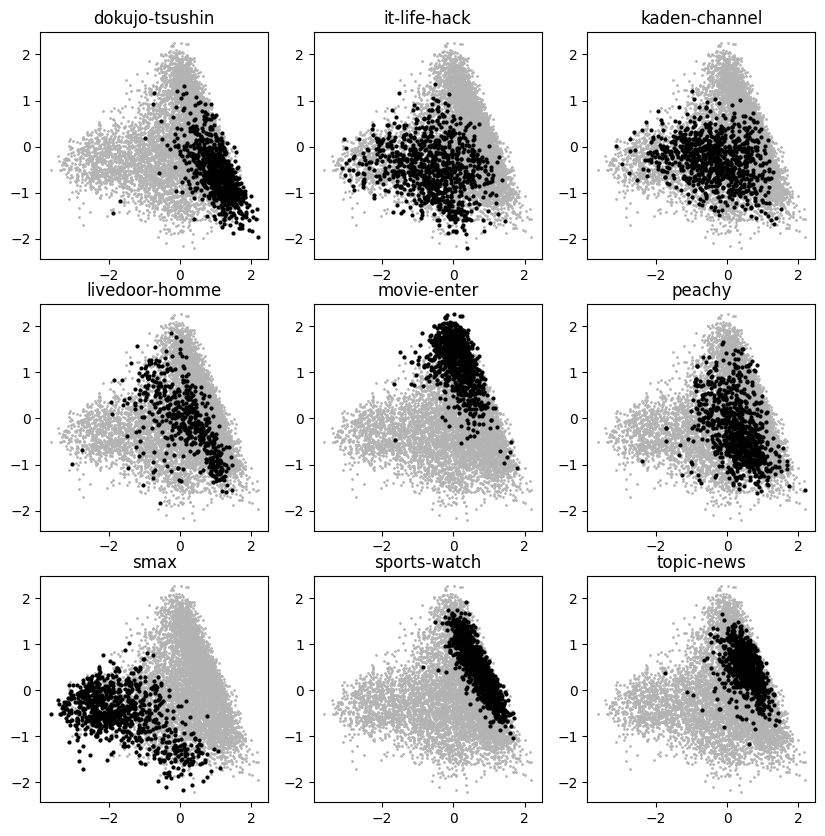

In [7]:
# 10-7
# -------------------------------------------------------------
# 目的（理論）：
# - PCA で 2 次元へ次元圧縮した文ベクトル（sentence_vectors_pca）を、
#   9 カテゴリー（labels ∈ {0..8}）ごとに小 multiples（3×3 サブプロット）で可視化する。
# - 各小図では「全体分布（薄い灰色）」を背景に描き、注目クラスのみ「黒」で上書きすることで、
#   クラスごとのクラスタリング傾向・重なり・境界の曖昧さを視覚的に比較できる。
# - PCA 可視化は「線形・分散最大化」に基づく投影であり、クラス分離が線形でない場合は
#   必ずしも明瞭にならない点に注意（t-SNE/UMAP などの非線形手法も状況によって有効）。
# 前提：
# - sentence_vectors_pca : ndarray 形状 [N, 2]（10-6 で PCA 済み）
# - labels               : ndarray 形状 [N]   （各サンプルのクラスID 0..8）
# - category_list        : 長さ 9 のラベル名リスト（labels の数値に対応）
# -------------------------------------------------------------

plt.figure(figsize=(10, 10))  # 全体キャンバス（インチ）。サブプロットを 3×3 で配置
for label in range(9):
    plt.subplot(3, 3, label + 1)  # 小図を (行=3, 列=3, インデックス=1..9) で配置

    # 対象クラスのブールマスク（True の行だけが該当クラス）
    index = labels == label

    # 背景：全サンプル（灰色・小さめマーカー）
    # ねらい：各クラス図でも “全体の地形” を参照できるようにする（文書密度や他クラスの散らばりがわかる）
    plt.plot(
        sentence_vectors_pca[:, 0],
        sentence_vectors_pca[:, 1],
        "o",
        markersize=1,
        color=[0.7, 0.7, 0.7],
    )

    # 前景：注目クラスのみ（黒・やや大きいマーカー）
    # ねらい：クラスの凝集度・位置・他クラスとの重なりを視認しやすくする
    plt.plot(
        sentence_vectors_pca[index, 0],
        sentence_vectors_pca[index, 1],
        "o",
        markersize=2,
        color="k",
    )

    # 小図タイトルにクラス名を表示（category_list と labels の対応が前提）
    plt.title(category_list[label])

# 備考（任意改善案；ここでは “コード変更はしない” 方針のためコメントのみ）：
# - plt.tight_layout() を最後に呼ぶとタイトルや軸ラベルの重なりを軽減できる。
# - 重なりが多い場合は alpha（透過）を付けると密度が見やすい（例：alpha=0.3）。
# - 座標軸スケール差で歪む場合は plt.axis('equal') や標準化を検討。
# - PCA は分散保持が目的でクラス分離を最適化しない。判別可視化なら LDA（クラス内/間分散比最大化）の併用も検討。